In [1]:
# import relevent modules
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sympy import *
from scipy.interpolate import CubicSpline
import pandas as pd
import os 
import shutil
import re

In [2]:
### change if needed
case = "A9_new"
prior = 'T3'

# input the scalar and cosmological parameter
scf_lambda = 1.4
scf_log_minus_beta = -10
redshift = 99

if prior == 'T3ph':
    scf_beta = -10**(scf_log_minus_beta)
    sign = "+" if scf_log_minus_beta >= 0 else ""
    Scf_beta = "-1e{}{}".format(sign, scf_log_minus_beta) if scf_beta != 0 else "0e+0"
else:
    scf_beta = -0.5
    # Find number of decimal places
    decimal = str(scf_beta).split('.')
    n_dec = len(decimal[1]) if len(decimal) > 1 else 0
    Scf_beta = "{:.{}e}".format(scf_beta, n_dec ) if scf_beta != 0 else "0e+0"
    #Scf_beta = "{:.{}e}".format(scf_beta, n_dec - 1) if scf_beta != 0 else "0e+0"
    Scf_beta = Scf_beta.replace("e+0", "e+").replace("e-0", "e-") if scf_beta != 0 else "0e+0"

# set the format of beta depending on the priors
beta = Scf_beta if prior == "T3ph" else scf_beta

# mean_file_dir = r"/Users/kinho123/Downloads/output/Lambda_{}_{}/{}/beta_{}_mean.txt".format(scf_lambda, prior, case, beta)
mean_file_dir = r"/Users/kinho123/Downloads/mphil_project/output/Cobaya_IDE_DESI2/{}.txt".format(case)


# Initialize dictionaries to hold the central values and uncertainties (optional)
parameter_values = {}
parameter_uncertainties = {}  # stores (plus_err, minus_err) or (sym_err, sym_err)

# Regex patterns to handle both "value ± err" and "A_s (central +plus -minus) × 10^-exp"
pm_pattern = re.compile(
    r'^(?P<name>.+?)\s+'
    r'(?P<val>[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*'
    r'(?:±|\+/-)\s*'
    r'(?P<err>[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*$'
)

As_pattern = re.compile(
    r'^(?P<name>A_s)\s+'
    r'\(\s*(?P<c>[-+]?\d*\.?\d+)\s*'
    r'\+?\s*(?P<p>[-+]?\d*\.?\d+)\s*'
    r'-\s*(?P<m>[-+]?\d*\.?\d+)\s*\)\s*'
    r'[×x]\s*10\^(?P<exp>[-+]?\d+)\s*$'
)

# A small normalizer for parameter names
def normalize_name(name: str) -> str:
    n = name.strip()
    n = n.replace(' ', '_')  # e.g., "omega_b h^2" -> "omega_b_h^2"
    return n

with open(mean_file_dir, 'r', encoding='utf-8') as f:
    for raw in f:
        line = raw.strip()
        if not line or line.lower().startswith('parameter'):
            continue

        # Try A_s special line first
        m_as = As_pattern.match(line)
        if m_as:
            name = normalize_name(m_as.group('name'))
            c = float(m_as.group('c'))
            p = float(m_as.group('p'))
            m = float(m_as.group('m'))
            exp = int(m_as.group('exp'))
            factor = 10.0 ** exp
            central = c * factor
            plus_err = p * factor
            minus_err = m * factor
            parameter_values[name] = central
            parameter_uncertainties[name] = (plus_err, minus_err)
            continue

        # Then try the generic "value ± err" format
        m_pm = pm_pattern.match(line)
        if m_pm:
            name = normalize_name(m_pm.group('name'))
            val = float(m_pm.group('val'))
            err = float(m_pm.group('err'))
            parameter_values[name] = val
            parameter_uncertainties[name] = (err, err)
            continue

        # If neither pattern matches, you can optionally log or ignore
        # print(f"Unparsed line: {line}")

# Convenience accessors for expected names
H_0 = parameter_values.get('H_0')  # km/s/Mpc
omega_b_h2 = parameter_values.get('omega_b_h^2')
omega_c_h2 = parameter_values.get('omega_c_h^2')
omega_m = parameter_values.get('omega_m')
omega_m_h2 = parameter_values.get('omega_m_h^2')
n_s = parameter_values.get('n_s')
A_s = parameter_values.get('A_s')      # dimensionless amplitude
z_re = parameter_values.get('z_re')

# Derived parameters
h_0 = round(H_0 * 1e-2, 6) if H_0 is not None else None  # h = H0/100
sigma8_0 = round(parameter_values.get('sigma8'), 6) if parameter_values.get('sigma8') is not None else None
n_s = round(n_s, 6) if n_s is not None else None

# Compute Omega_b0 from omega_b h^2 and h^2
Omega_b0 = None
if omega_b_h2 is not None and h_0 is not None:
    Omega_b0 = round(omega_b_h2 / (h_0 ** 2), 6)

Omega_m0 = round(omega_m, 6) if omega_m is not None else None
Omega_lbd0 = round(1 - Omega_m0, 6) if Omega_m0 is not None else None

### change if needed
# parameter category (fixed, vary )
params = "fixed"
# momentum coupling constant

print(h_0, sigma8_0, n_s, omega_b_h2, Omega_m0, Omega_lbd0)

# Optional: if you want to inspect parsed values and uncertainties:
# print(parameter_values)
print( Scf_beta)


0.6583 0.7566 0.9699 0.02237 0.3214 0.6786
-5.0e-1


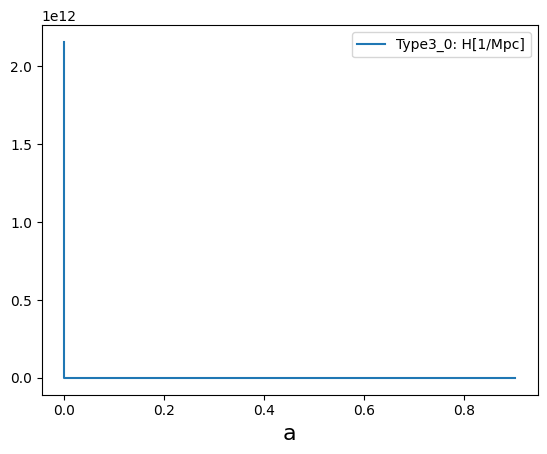

In [3]:
files = [r'/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/Lambda_{}_{}/{}/beta_{}_00_background.dat'.format(scf_lambda, prior, case, beta)]
data = []
for data_file in files:
    data.append(np.loadtxt(data_file))
roots = ['Type3_0']

fig, ax = plt.subplots()

index, curve = 0, data[0]
y_axis = ['H[1/Mpc]']
tex_names = ['H [1/Mpc]']
x_axis = 'a'
ylim = []
xlim = []
ax.plot(1/(1+curve[::200, 0]), curve[::200, 3])

ax.legend([root+': '+elem for (root, elem) in
    itertools.product(roots, y_axis)], loc='best')

ax.set_xlabel('a', fontsize=16)
plt.show()


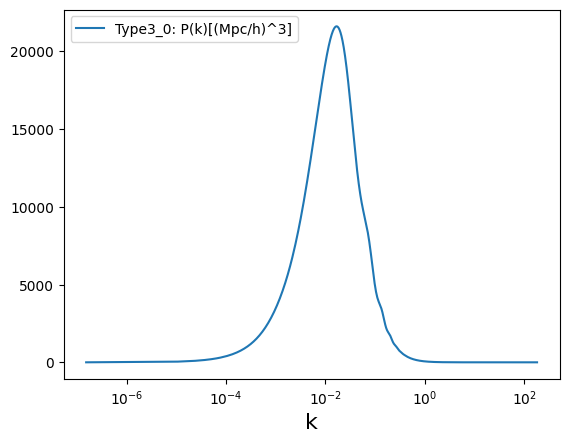

In [4]:
# For p(k) spectrum


files = [r'/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/Lambda_{}_{}/{}/beta_{}_00_z1_pk.dat'.format(scf_lambda, prior, case, beta)]
data = []
for data_file in files:
    data.append(np.loadtxt(data_file))
roots = ['Type3_0']

fig, ax = plt.subplots()

index, curve_pk = 0, data[0]
y_axis = ['P(k)[(Mpc/h)^3]']
tex_names = ['P(k)[(Mpc/h)^3]']
x_axis = 'k'
ylim = []
xlim = []
 
ax.plot(curve_pk[:,0], curve_pk[:,1])

ax.legend([root+': '+elem for (root, elem) in
    itertools.product(roots, y_axis)], loc='best')

ax.set_xlabel('k', fontsize=16)
plt.xscale('log')
plt.show()


# Sample the whole datapoint

In [5]:
# Sample the whole datapoints
# calculate co-efficient h1, h3 (note the whole datapoint is employed)
G = 6.6743e-11
Mpc = 3.08567758127e19 # Mpc in km
Mass_sun = 1.9885e30 # Mass of sun in kg
box_size = 100 # box size of n-body simulation, in units of (Mpc*h^-1)
particle_num = 512 # particle number per Mpc*h^-1
phi_dot_og = curve[:, 17]
scal_og = 1/(1+curve[:, 0]) 
Hubble_og = curve[:, 3]
conformal_Hubble = scal_og*Hubble_og # conformal hubble parameter H
con_unit = 60*60*24*365*1e9/(Mpc) # convert H(a) relevant calculations from km/s*mpc to 1/Gyr
conversion_factor = 2.99792458e5 # unit change from (Mpc)^-1 to km/s/Mpc, speed of light in km/s
conversion_factor_rho = (Mpc*1e3)**3/Mass_sun # the unit change from km/s/Mpc to 1/s. Reference: https://en.wikipedia.org/wiki/Friedmann_equations
Hubble_km_s = curve[:, 3]*conversion_factor # Hubble constant in km/s/Mpc
h_a = Hubble_km_s/100 # H(a)/100 km/s/Mpc
omega_cdm = (curve[:, 10])/(curve[:, 12])
omega_m = omega_cdm + (curve[:, 9])/(curve[:, 12])
#rho_crit = curve[:, 12]*(conversion_factor/Mpc)**2*conversion_factor_rho*(3/(8*np.pi*G))*(h)**-2 # convert critical density from unit of kg*m^-3*h**2 to 10e10*M_sun*Mpc^-3**2
rho_cdm = 3*omega_cdm*(Hubble_og)**2 # 3 is from the planck mass unit
mass_cdm = ((rho_cdm)*(box_size)**3/(particle_num)**3)*1e-10
#(Hubble_og/curve[-1, 3])**-2
Z_og = -phi_dot_og/scal_og
F_og = scf_beta*(Z_og)**2   #coupled energy between scalar field and DM
F_og_z = 2*scf_beta*(Z_og)
F_og_zz = 2*scf_beta
V_og_phi = -scf_lambda*curve[:, 18]
phi_dot_dot_og = (-2*Hubble_og*phi_dot_og*(1-2*scf_beta) - scal_og**2*V_og_phi)/(1-2*scf_beta)
h1_og = (4*(scf_beta*phi_dot_og)**2)/(((scal_og)**2)*(rho_cdm) - 2*(scf_beta)*(phi_dot_og)**2) # factor of 3 accounts for the multiplication of 8piG/3
#h2_og = (((8*(scf_beta)**2 - 2*(scf_beta))*(phi_dot_og)**2 
         #+ (8*(scf_beta)**2 - 4*(scf_beta))*phi_dot_og*phi_dot_dot_og*(1/Hubble_og))
         #/(scal_og**2*(curve[:, 10]) - 2*scf_beta*(phi_dot_og)**2))
h2_og = ((4*(scf_beta)*( 3/2 - 2*scf_beta)*(phi_dot_og)**2 
        + 4*(scf_beta)*(phi_dot_og)*(scal_og)**2*(V_og_phi)*(1/conformal_Hubble))
        / (((scal_og)**2)*rho_cdm - 2*scf_beta*(phi_dot_og)**2))
h3_og = (2*(scf_beta)*phi_dot_og**2)/(((scal_og)**2)*(rho_cdm) - 2*(scf_beta)*(phi_dot_og)**2) 

mod_grav = (1 + h3_og)/(1 + h1_og)
c1 = (1 + h2_og)/(1 + h1_og)
acc = -(((h2_og - h1_og)*(scal_og))*(Hubble_km_s)*(con_unit))/(1 + h1_og) # DM particles in the simulation will receive an additional acceleration pro- portional to its velocity
                                                             # H_0 removed from stad2739
                                                             # Also convert the H(a) from km/(s*mpc) to 1/Gyr

def panda_dataframe_full(var_name, var):

    dat = {'a': scal_og, var_name: var}
    df = pd.DataFrame(dat)
    return df
h1_df = panda_dataframe_full('h1', h1_og)
h2_df = panda_dataframe_full('h2', h2_og)
h3_df = panda_dataframe_full('h3', h3_og)
acc

array([-0.00000000e+00, -5.57822092e-56, -1.11680411e-55, ...,
       -6.94656262e-02, -6.95590112e-02, -6.96524445e-02])

In [6]:
Hubble_km_s[-1]

65.82989155294328

In [7]:
rho_cdm,curve[:, 10],  2*(scf_beta)*(phi_dot_og)**2

(array([3.90072857e+19, 3.89467044e+19, 3.88862172e+19, ...,
        3.91287311e-08, 3.90679612e-08, 3.90072857e-08]),
 array([1.30024286e+19, 1.29822348e+19, 1.29620724e+19, ...,
        1.30429104e-08, 1.30226537e-08, 1.30024286e-08]),
 array([-0.00000000e+00, -4.26173221e-64, -1.70557919e-63, ...,
        -7.14883985e-09, -7.15941526e-09, -7.17000191e-09]))

In [8]:
(3)*(curve[0, 13]), (1/2 - (scf_beta))*(phi_dot_og[0])**2 + curve[0, 18], (1/2 - (scf_beta))*(phi_dot_og[-1])**2 + curve[-1, 18]/(3*(curve[-1, 12]))
(curve[-1, 3])**2, (curve[-1, 12])

(4.821752045938724e-08, 4.821752045938e-08)

In [9]:
(1/3)*((1/2 - (scf_beta))*(phi_dot_og[-1])**2 + curve[-1, 18])/((curve[-1, 12]))\
, np.sqrt((1/3)*((1/2 - (scf_beta))*(phi_dot_og[-1])**2 )/((curve[-1, 12]))) \
, np.sqrt(((1/6)*(phi_dot_og[-1])**2 )/(curve[-1, 12])) \
, np.sqrt((1/3)*(curve[-1, 18] )/((curve[-1, 12]))), (curve[-1, 9] )/((curve[-1, 12])) \
, (curve[-1, 8]+ curve[-1, 11])/((curve[-1, 12])), Hubble_og

(0.678621373776207,
 0.2226366053678433,
 0.1574278533959553,
 0.7931294444959728,
 0.051620202608485696,
 9.651584462115744e-05,
 array([2.15725988e+12, 2.15502571e+12, 2.15279386e+12, ...,
        2.19728522e-04, 2.19656675e-04, 2.19584882e-04]))

In [10]:
print(r"c1: {} , c2: {}".format(c1[-1],mod_grav[-1]))

c1: 2.035278419901921 , c2: 0.7311952687039203


In [11]:
cal= ((curve[:, 13])/(curve[:, 12]))
theory= ((curve[-1, 13])/(curve[-1, 12]))*(scal_og)**(-3*(1+((curve[:, 14])/(curve[:, 13]))))*((curve[-1, 3])/(curve[:, 3]))**2

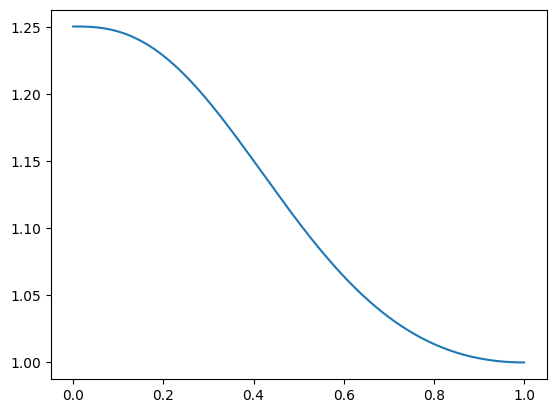

In [12]:
plt.plot(scal_og,cal/theory )

# Do the extrapolation

In [13]:
extra_n = 3500

def plot_and_cubic(files, n):

    fig, ax = plt.subplots()
    y_axis = ['H[1/Mpc]']
    tex_names = ['H [1/Mpc]']
    x_axis = 'a'
    ylim = []
    xlim = []

    extra = CubicSpline(1 / (1 + curve[:, 0]), curve[:, n], extrapolate=True)
    a = np.linspace(0, 1.1, extra_n)
    ax.plot(a, extra(a))
    ax.plot(1 / (1 + curve[::200, 0]), curve[::200, n])
    ax.set_yscale('log')

    ax.legend([root + ': ' + elem for (root, elem) in itertools.product(roots, y_axis)], loc='best')

    ax.set_xlabel('a', fontsize=16)

    return fig, ax

def extra(n):
    extra = CubicSpline(1 / (1 + curve[:, 0]), curve[:, n], extrapolate=True)
    a = np.linspace(0, 1.1, extra_n)
    
    return extra(a)

def extra_eq(func): # Deals with more complex equations
    extra_eq = CubicSpline(1 / (1 + curve[:, 0]), func, extrapolate=True)
    a = np.linspace(0, 1.1, extra_n)
    
    return extra_eq(a)
    


In [14]:
# filter out a < 1e-4

given_array = scal_og  # Replace `[...]` with your actual array

# Define the ranges
ranges = [
    (1e-4, 1e-3),
    (1e-3, 1e-2),
    (1e-2, 1e-1),
    (1e-1, 1)
]

# Initialize an empty list to store the sampled indices
sampled_indices = []

# Extract 50 periodic points from each range, including the last index
for start, end in ranges:
    # Find the indices within the range
    start_index = np.argmax(given_array >= start)
    end_index = np.argmax(given_array >= end)

    # Calculate the step size
    step_size = max(1, int((end_index - start_index) / 49))

    # Extract the indices within the range, including the last index
    indices = np.arange(start_index, end_index+1, step_size)

    sampled_indices.extend(indices)

# Append the index of the last datapoint
sampled_indices.append(len(given_array) - 1)

# Convert the sampled indices to a NumPy array
sampled_indices = np.array(sampled_indices)
 


In [15]:
index = np.argmax(scal_og >= 1e-4)

def curve_new(func):
    return func[sampled_indices]

#Hubble_og[-1],scal_og[-1], curve[-1, 3]

# Convert extrapolation to pandas dataframe

In [16]:
def panda_dataframe_extra(var_name, var):
    a = np.linspace(0, 1.1, extra_n)

    dat = {'a': a, var_name: var}
    df = pd.DataFrame(dat)
    return df

Hubble_extra = panda_dataframe_extra('Hubble', extra(3)/curve[-1, 3])
#dm_mass_extra = panda_dataframe_extra('Dm_mass', (extra(10)/extra(12)*(h)**2))
dm_mass_extra = panda_dataframe_extra('omega_m', (extra(10)+extra(9))/extra(12))


#Hubble_extra.loc[1895], Hubble_extra.loc[1973]

# Get two points a > 1 and concatenate 

def panda_dataframe_filter(var_name, var):
    a = np.linspace(0, 1.1, extra_n)
    
    index_1 = np.argmax((a >= 1.0480) & (a <= 1.0483)) #index of first extrapolated scale factor
    index_2 = np.argmax((a >= 1.0990) & (a <= 1.0997)) #index of second extrapolated scale factor
    dat = {'a': a, var_name: var}
    df = pd.DataFrame(dat)
    df1 = df.loc[index_1]  #first value
    df2 = df.loc[index_2]  #second value
    df_fil = pd.concat([df1.to_frame().T, df2.to_frame().T],  ignore_index=True)
    #df_fil = df_fil.reset_index(drop=True)

    return df_fil



# Filtering out the datapoint to 100 to 200 in number and attaching the a > 1 point to original datapoints

In [17]:
#EOS = curve_new[14][::rate]/curve_new[13][::rate]

def panda_dataframe(var_name, var):

    dat = {'a': curve_new(scal_og), var_name: var}
    df = pd.DataFrame(dat)
    return df

Hubble = panda_dataframe('Hubble', curve_new(Hubble_og)/curve[-1, 3])
#Dm_mass = panda_dataframe('Dm_mass', curve_new(mass_cdm))
acc_dm = panda_dataframe('acc_dm', curve_new(acc))
acc_mod_grav = panda_dataframe('acc_grav', curve_new(mod_grav))
Omega_m = panda_dataframe('Omega_m', curve_new(omega_m))

#cs_eff = -3*curve_new[3][::rate]*(Redshift[0])**2*2/() 

#acc_dm
#acc_mod_grav
Omega_m.iloc[:,0][149]

0.09827087219643976

In [18]:
# Attach  the a > 1 points to original datapoints¶
def panda_add(var_name, var, var_fil):
    df1 = panda_dataframe(var_name, var)
    df2 = panda_dataframe_filter(var_name, var_fil)
    result = pd.concat([df1, df2], ignore_index=True)
    return result


omega_cdm_ext = (extra(10))/(extra(12))
                 
#rho_crit_ext = (extra(12))*(conversion_factor/Mpc)**2*conversion_factor_rho*1e-10*(3/(8*np.pi*G))*(h)**-2 
#mass_cdm_ext = omega_cdm_ext*rho_crit_ext*(box_size)**3/(particle_num)**3
                                                     
                 
Hubble_fin = panda_add('Hubble', curve_new(Hubble_og)/curve[-1, 3], extra(3)/curve[-1, 3])
#Dm_mass_fin = panda_add('Dm_mass', curve_new(mass_cdm), mass_cdm_ext)
acc_dm_fin = panda_add('acc_dm', curve_new(acc), extra_eq(acc) )
acc_mod_grav_fin = panda_add('acc_mod_grav', curve_new(mod_grav), extra_eq(mod_grav) )
omega_m_fin = panda_add('omega_m', curve_new(omega_m), extra_eq(omega_m) )


Hubble_fin
acc_mod_grav_fin
acc_dm_fin

,a,acc_dm
0,0.000100,-1.321760e-23
1,0.000105,-1.738914e-23
2,0.000110,-2.287274e-23
3,0.000115,-3.007949e-23
4,0.000121,-3.954880e-23
...,...,...
198,0.937776,-5.847378e-02
199,0.982539,-6.650359e-02
200,1.000000,-6.965244e-02
201,1.048128,-7.831214e-02


# Convert panda to excel / Duplicate folder and files

In [19]:
# note -3e-1 is not always the scenario of interest, it's mentioned because it serves as a reference folder
panda_name = [Hubble_fin, acc_dm_fin, acc_mod_grav_fin]
file_name = ['hubble_table', 'drag_table', 'varg_table'] #'dmmass_table'
output_dir = r'/Users/kinho123/Downloads/mphil_project/Momentum/{}/{}'.format(Scf_beta, case)
# copy and paste IC folder and related parameter to folder
copy_file_name = ['momentum.param', 'outputs.txt', 'slurm.sh']
new_destination_folder = output_dir + '/IC/'
source_folder = r'/Users/kinho123/Downloads/mphil_project/Momentum/-2e-1_old/{}_params/IC/'.format(params)
#os.makedirs(output_dir + '/result') # generate result folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir + '/result')  # generate a folder of scf_beta
    for cp_file in copy_file_name:
        shutil.copy(r'/Users/kinho123/Downloads/mphil_project/Momentum/-2e-1_old/{}_params/{}'.format(params, cp_file), output_dir)
else:
    print("Destination folder already exists. Skipping the copying process.")
# Check if the destination folder already exists
if not os.path.exists(new_destination_folder):
    shutil.copytree(source_folder, new_destination_folder)
    os.remove(new_destination_folder + "Momentum_z127.dat")
    print("Copying default files and deleting the initial power spectrum")
else:
    print("IC folder already exists. Skipping the copying process.")
    

# convert panda dataframes to excel
    
for panda, file in zip(panda_name, file_name):
    file_path = output_dir + r'/{}.txt'.format(file)
    if file != 'varg_table':
        panda.to_csv(file_path, header = False, index = False, float_format='%.10f' )
    else:
        panda.to_csv(file_path, header = False, index = False, float_format='%.18f' )

        

Copying default files and deleting the initial power spectrum


# Modify the sh and param files 

In [20]:
# Convert number to string
def n_to_s(num):
    if num > 0:
        return f"plus_{num}"
    elif num < 0:
        return f"minus_{abs(num)}"
    else:
        return f"zero_{num}"

def read_param_file(file_path):
    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file.readlines()]
    return lines

def write_param_file(file_path, lines):
    with open(file_path, 'w') as file:
        for line in lines:
            file.write(line + '\n')

def edit_param_lines(file_path, line_edits):
    # Read the current lines from the file
    lines = read_param_file(file_path)
    
    for key, new_value in line_edits.items():
        found = False
        for i, line in enumerate(lines):
            if line.startswith(key):
                
                # Print the original line
                print(f"Original line {i + 1}: {line}")

                # Update the specific line
                lines[i] = new_value

                found = True
                break  # Stop searching after the first match

        if found:
            # Write the updated lines back to the file
            write_param_file(file_path, lines)
            print(f"Line starting with '{key}' updated to: {new_value}")
        else:
            print(f"No line starting with '{key}' found.")

n_grid = 1024
n_sample = 1024
Boxsize = 1000 #box size (1000 Mpc)
allocation_fac = 0.8
glass_fac = 16
file_edits = {
    "/Users/kinho123/Downloads/mphil_project/Momentum/{}/{}/IC/2lpt_Momentum.param".format(Scf_beta, case): {
        "Nmesh": "Nmesh\t\t\t{}".format(n_grid),  
        "Nsample": "Nsample\t\t\t{}".format(n_sample),
        "Box": "Box\t\t\t{}".format(Boxsize*1e3),
        "FileBase": "FileBase\tMOM_{}_{}".format(n_grid, Boxsize),
        "OutputDir": "OutputDir\t\t/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/IC".format(case),
        "GlassFile": "GlassFile\t\t/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/IC/ccvt_64".format(case),
        "GlassTileFac": "GlassTileFac\t\t{}".format(glass_fac),
        "Omega": "Omega\t\t\t{}\t% Total matter density  (at z=0)".format(Omega_m0),
        "OmegaLambda": "OmegaLambda\t\t\t{}\t% Cosmological constant (at z=0)".format(Omega_lbd0),
        "OmegaBaryon": "OmegaBaryon\t\t\t{}\t% Baryon density        (at z=0)".format(Omega_b0),
        "HubbleParam": "HubbleParam\t\t\t{}\t% Hubble parameter (may be used for power spec parameterization)".format(h_0),
        "Redshift": "Redshift\t\t\t{}\t% Starting redshift".format(redshift),
        "Sigma8": "Sigma8\t\t\t{}\t% power spectrum normalization".format(sigma8_0),
        "FileWithInputSpectrum": "FileWithInputSpectrum\t\t/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/IC/Momentum_z{}.dat % filename of tabulated input spectrum".format( case, redshift),
        "FileWithInputHubble": "FileWithInputHubble\t\t/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/hubble_table.txt % filename of the tabulated hubble diagram".format(case),
        "PrimordialIndex": "PrimordialIndex\t\t{}".format(n_s)
    },
    "/Users/kinho123/Downloads/mphil_project/Momentum/{}/{}/momentum.param".format(Scf_beta, case): {
        "InitCondFile": "InitCondFile\t\t/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/IC/MOM_{}_{}".format(case, n_grid, Boxsize), 
        "OutputDir": "OutputDir\t\t/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/result".format(case),
        "OutputListFilename": "OutputListFilename\t/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/outputs.txt".format(case),
        "TimeBegin": "TimeBegin\t\t0.01  % z={}, Begin of the simulation".format(redshift),  
        "Omega0": "Omega0\t\t{}".format(Omega_m0),
        "OmegaLambda": "OmegaLambda\t\t{}".format(Omega_lbd0),
        "OmegaBaryon": "OmegaBaryon\t\t{}".format(Omega_b0),
        "HubbleParam": "HubbleParam\t\t{}".format(h_0),
        "BoxSize": "BoxSize\t\t{}".format(Boxsize*1e3),
        "TreeAllocFactor": "TreeAllocFactor\t\t{}".format(allocation_fac)
    },
    "/Users/kinho123/Downloads/mphil_project/Momentum/{}/{}/slurm.sh".format(Scf_beta, case): {
        "value=": "value={}".format(Scf_beta),  
        'singularity exec': 'mpirun -n 16 singularity exec /opt/share/singularity/Gadget2/Gadget2_environment_intempi_intel2023.2_alma8.8.sif ./2LPTicMOM /scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/IC/2lpt_Momentum.param'.format(case),
        'mpirun -n 64': 'mpirun -n 128 singularity exec /opt/share/singularity/Gadget2/Gadget2_environment_intempi_intel2023.2_alma8.8.sif /project/MCChu/khluo/ME-Gadget-public/src/ME-Gadget /scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/{}/momentum.param -r  > log_z99.txt'.format(case),
    }
}  # Add more file paths and their specific edits as needed

for file_path, edits in file_edits.items():
    edit_param_lines(file_path, edits)

Original line 2: Nmesh           512       % This is the size of the FFT grid used to
Line starting with 'Nmesh' updated to: Nmesh			1024
Original line 6: Nsample         256       % sets the maximum k that the code uses,
Line starting with 'Nsample' updated to: Nsample			1024
Original line 15: Box             1000000.0   % Periodic box size of simulation
Line starting with 'Box' updated to: Box			1000000.0
Original line 17: FileBase         MOM_512_100                 % Base-filename of output files
Line starting with 'FileBase' updated to: FileBase	MOM_1024_1000
Original line 18: OutputDir        /project/MCChu/khluo/simulations/Momentum/Bao/minus_0.5/fixed_params/IC  % Directory for output
Line starting with 'OutputDir' updated to: OutputDir		/scratch/s1/MCChu/khluo/Gadget_results/DESI_DR2/A9_new/IC
Original line 20: GlassFile        /project/MCChu/khluo/simulations/Momentum/Bao/minus_0.5/fixed_params/IC/ccvt_64
Line starting with 'GlassFile' updated to: GlassFile		/scratch/s1/MCChu

# Filter out k<1e-4 (h/Mpc) for the power spectrum p(k) at z > 0


In [21]:
files = [r'/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/Lambda_{}_{}/{}/beta_{}_00_z2_pk.dat'.format(scf_lambda, prior, case, beta)]
data = []
for data_file in files:
    data.append(np.loadtxt(data_file))


index, curve_pk_zhigh = 0, data[0]

index_pk = np.argmax(curve_pk_zhigh[:, 0] > 1e-4)
Curve_pk_zhigh = curve_pk_zhigh[index_pk:, :]

def count_zeros_after_decimal(numbers):
    zero_counts = []
    for number in numbers:
        decimal_part = str(number).split('.')[1]  # Get the decimal part as a string
        non_decimal_part = str(number).split('.')[0] 
        count = 0
        if non_decimal_part == '0':
            for digit in decimal_part:
                if digit == '0':
                    count += 1
                else:
                    break            
        else:
            for power in non_decimal_part:
                count -= 1
            
        zero_counts.append(count)
    return zero_counts

# Example usage
numbers_0 = [ "{:.20f}".format(i) for i in Curve_pk_zhigh[:,0]]
numbers_1 = [ "{:.20f}".format(i) for i in Curve_pk_zhigh[:,1]] 
zero_counts_0 = count_zeros_after_decimal(numbers_0)
zero_counts_1 = count_zeros_after_decimal(numbers_1)

In [22]:
signs_0 = np.array(['-' if num > 0 else '+' for num in zero_counts_0])
signs_1 = np.array(['-' if num > 0 else '+' for num in zero_counts_1])
formatted_number_0 = ["{:.5f}E{}0{}".format(i*10**j, k, np.abs(j)) for i,k, j  in zip(Curve_pk_zhigh[:,0], signs_0, zero_counts_0) ]
formatted_number_1 = ["{:.5f}E{}0{}".format(i*10**j, k, np.abs(j)) for i,k, j  in zip(Curve_pk_zhigh[:,1], signs_1, zero_counts_1) ]
#print(formatted_number_0)

In [23]:
dat = {'k': formatted_number_0, 'P(k)': formatted_number_1}
df = pd.DataFrame(dat)

file_name = 'momentum_z{}'.format(redshift)
file_path = '/Users/kinho123/Downloads/mphil_project/Momentum/' + r'{}/{}.dat'.format(Scf_beta, file_name)
df.to_csv(file_path, sep='\t', index=False)

In [24]:
file_name_fin = 'Momentum_z{}'.format(redshift)
file_path_fin = new_destination_folder + r'{}.dat'.format(file_name_fin)
df_Momentum = pd.read_csv(file_path)
df_Momentum = df_Momentum.replace('\t', '     ', regex=True)
df_Momentum.to_csv(file_path_fin, header=False, index=False)
df_Momentum

if os.path.exists(file_path):
    os.remove(file_path)

# Read other files

In [25]:
# read values of lambda baryons, cdm, and scalar field (dark energy) at z = 0 

files = [r'/Users/kinho123/Downloads/mphil_project/output/DESI_2_Cobaya/Lambda_{}_{}/{}/beta_{}_00_background.dat'.format(scf_lambda, prior, case, beta)]
data = []
for data_file in files:
    data.append(np.loadtxt(data_file))

index, curve = 0, data[0]
rho_crit_0 = curve[-1, 12]
lamda_cdm_0 = curve[-1,10]/rho_crit_0
lamda_scf_0 = curve[-1,13]/rho_crit_0
lamda_b_0 = curve[-1,9]/rho_crit_0
lamda_m_0 = lamda_cdm_0 + lamda_b_0 
lamda_cdm_0, lamda_scf_0, lamda_b_0, lamda_m_0

(0.2696619077705098,
 0.6786213737762729,
 0.051620202608485696,
 0.3212821103789955)

# Calculate the value of Sigma_8

In [26]:
k = curve_pk[:, 0]
p_k = curve_pk[:, 1]
W = 3*(np.sin(k*8) - k*(8)*np.cos(k*8))/(k*8)**3
sigma_8 = k**2*p_k*W**2
# Perform numerical integration using the trapezoidal rule
integral = (1/(2*(pi)**2))*np.trapz(sigma_8, k)

sigma_8 = (integral)**(1/2)
print(r'Value of sigma_8: {}'.format(float(sigma_8)))

Value of sigma_8: 0.7677937034144946
